In [1]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

print(f"tensorflow: {tf.__version__}")
print(f"keras: {tf.keras.__version__}")

tensorflow: 2.0.0-beta1
keras: 2.2.4-tf


In [3]:
data_dir = "data/GSE92742_Broad_LINCS"
out_dir = "data/output"

fnames = [
    "Level3_INF_mlr12k_n1319138x12328.gctx",
    "gene_info.txt",
    "inst_info.txt",
    "pert_info.txt",
    "cell_info.txt",
]

fpaths = {
    "_".join(f.split(".")[0].split('_')[:2]): f"{data_dir}/{f}" for f in fnames
}

### Step 1: Load data and extract untreated samples for DE analysis
#### Load data
Extract all samples for training model (VCAP, MCF7, PC3), but filter for untreated and save for DE analysis in R.

In [4]:
from lib.utils import load_data

pert_types = [
    "trt_cp",  # treated with compound
    "ctl_vehicle",  # control for compound treatment (e.g DMSO)
    "ctl_untrt",  # untreated samples
]

cell_ids = ["VCAP", "MCF7", "PC3"]  # prostate tumor  # breast tumor  # prostate tumor

# Load Data
dset = load_data(
    fpaths["Level3_INF"], 
    fpaths["inst_info"], 
    fpaths["cell_info"], 
    fpaths["gene_info"], 
    pert_types, 
    cell_ids
)

dset

<LINCS Dataset: (samples: 333,523, genes: 978)>

#### Sample controls and save to disk 
Extract the control samples for DE.

In [5]:
ctrl_data = dset.filter_rows(pert_type=["ctl_vehicle", "ctl_untrt"])
ctrl_data.sample_rows(meta_groups="cell_id", size=100).to_tsv(out_dir, name='control')

#### Create model


In [6]:
from lib.models import AutoEncoder

tf.random.set_seed(42)
np.random.seed(42)

ae = AutoEncoder(dset)

In [7]:
h_size = 32
ae.compile_model([128, h_size, 128], dropout_rate=0.15)
ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 978)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               125312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0

#### Train Model

In [8]:
ae.fit(epochs=10, batch_size=64)

W0716 14:38:15.428186 139765168355136 deprecation.py:323] From /Users/manz01/miniconda3/envs/lincs-gpu/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
3335/3335 [==============================] - 17s 5ms/step - loss: 0.0092 - cosine_similarity: 0.9883 - pearsons_corrcoef: 0.8592 - val_loss: 0.0062 - val_cosine_similarity: 0.9919 - val_pearsons_corrcoef: 0.8896
Epoch 2/10
3335/3335 [==============================] - 14s 4ms/step - loss: 0.0060 - cosine_similarity: 0.9921 - pearsons_corrcoef: 0.8866 - val_loss: 0.0049 - val_cosine_similarity: 0.9935 - val_pearsons_corrcoef: 0.9145
Epoch 3/10
3335/3335 [==============================] - 15s 4ms/step - loss: 0.0052 - cosine_similarity: 0.9930 - pearsons_corrcoef: 0.9104 - val_loss: 0.0049 - val_cosine_similarity: 0.9935 - val_pearsons_corrcoef: 0.9150
Epoch 4/10
3335/3335 [==============================] - 15s 4ms/step - loss: 0.0050 - cosine_similarity: 0.9932 - pearsons_corrcoef: 0.9097 - val_loss: 0.0047 - val_cosine_similarity: 0.9936 - val_pearsons_corrcoef: 0.9183
Epoch 5/10
3335/3335 [==============================] - 15s 4ms/step - loss: 0.0049 - cosine_similarity: 0.9

In [30]:
test_loss = ae.evaluate()
print(f"loss: {test_loss}")

1668/1668 [==============================] - 3s 2ms/step - loss: 0.0047 - cosine_similarity: 0.9936 - pearsons_corrcoef: 0.9294
loss: [0.004691248724730663, 0.99364746, 0.9293822]


#### Examine hidden output for control samples

In [10]:
# Extract control samples from testing data
test_ctrl_data = ae.test.filter_rows(pert_type=["ctl_vehicle", "ctl_untrt"])

encoder = tf.keras.Model(inputs=ae.model.layers[0].input, outputs=ae.model.layers[3].output)

### Zero-out method

In [11]:
import altair as alt
from lib.hidden_embedding import HiddenEmbedding

# Initialize hidden embedding class
he = HiddenEmbedding(test_ctrl_data, encoder)

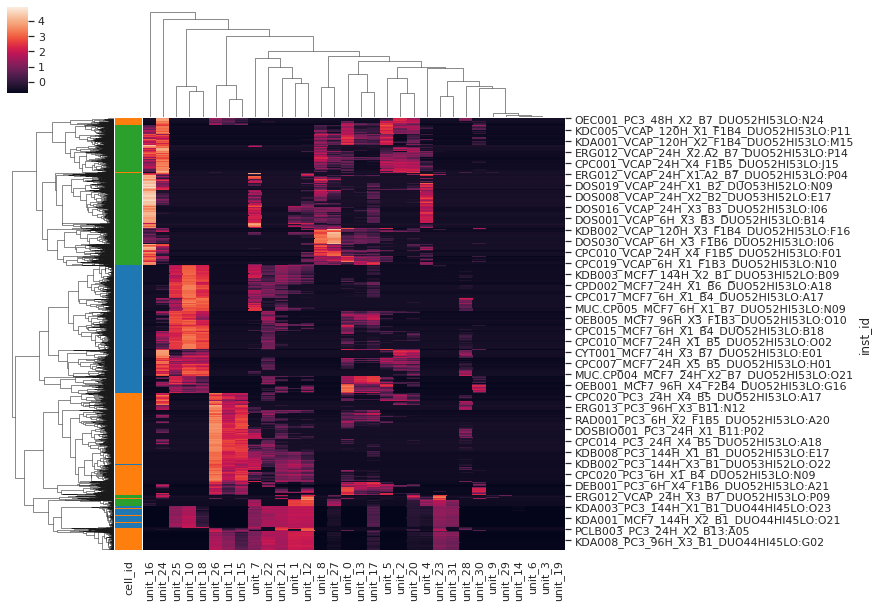

In [12]:
# Examine hidden activations 
he.plot_clustermap()

/Users/manz01/miniconda3/envs/lincs-gpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


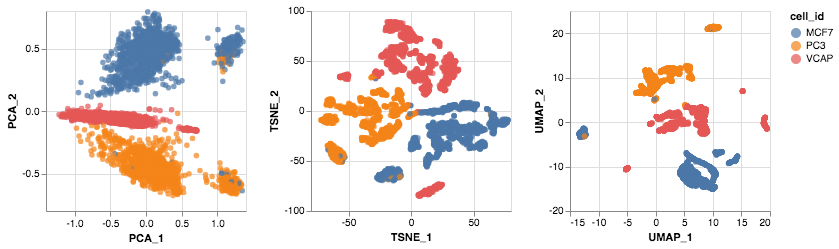

In [13]:
# compare with embedding projections
embedding_plots = [he.plot_embedding(e).properties(width=200, height=200) for e in ["PCA", "TSNE", "UMAP"]]
alt.hconcat(*embedding_plots)

In [14]:
# Zero out each gene for each sample and examine difference in hidden output
he.zero_out_genes()

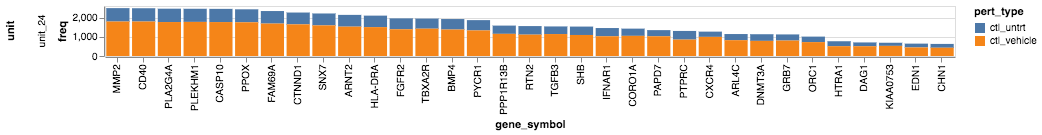

In [22]:
he.plot_unit_counts("pert_type", units=[24], count_thresh=500, k_max=25)

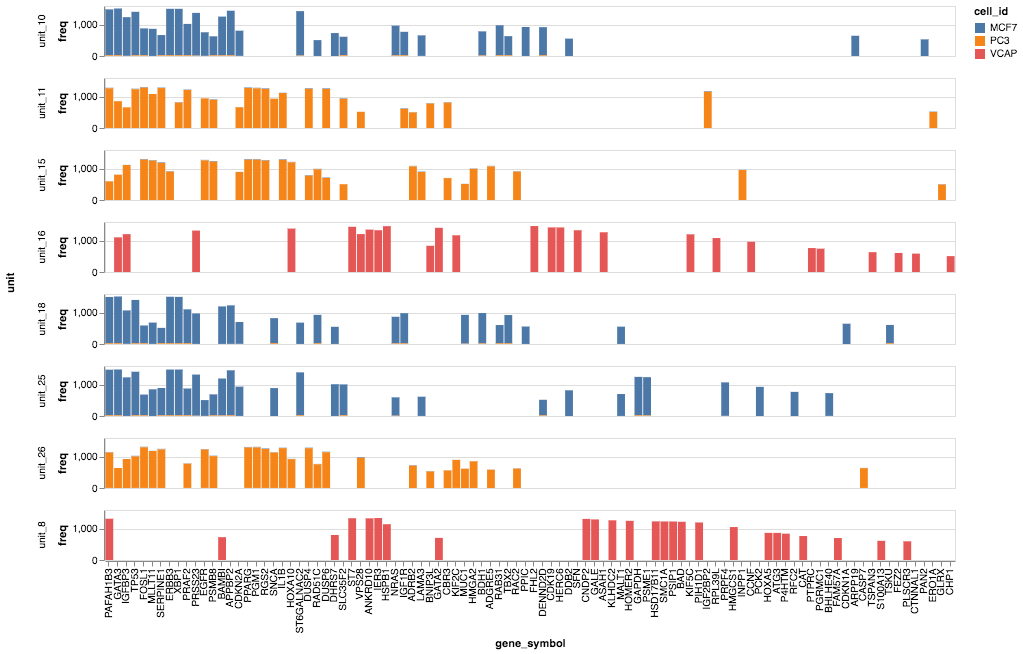

In [23]:
selected_units = [16,8,18,25,10,11,26, 15] # selected units from clustermap
he.plot_unit_counts("cell_id", units=selected_units, count_thresh=500, k_max=25)

In [24]:
genes_by_unit = he.get_genes_by_unit("cell_id", units=selected_units, count_thresh=500, k_max=25)

#### Gene set analysis

In [32]:
from lib.enrichr import EnrichrQuery
databases = ["GO_Biological_Process_2018", "MSigDB_Oncogenic_Signatures", "KEGG_2015"]

/Users/manz01/miniconda3/envs/lincs-gpu/lib/python3.6/site-packages/altair/utils/core.py:90: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  "Defaulting to nominal.".format(typ))


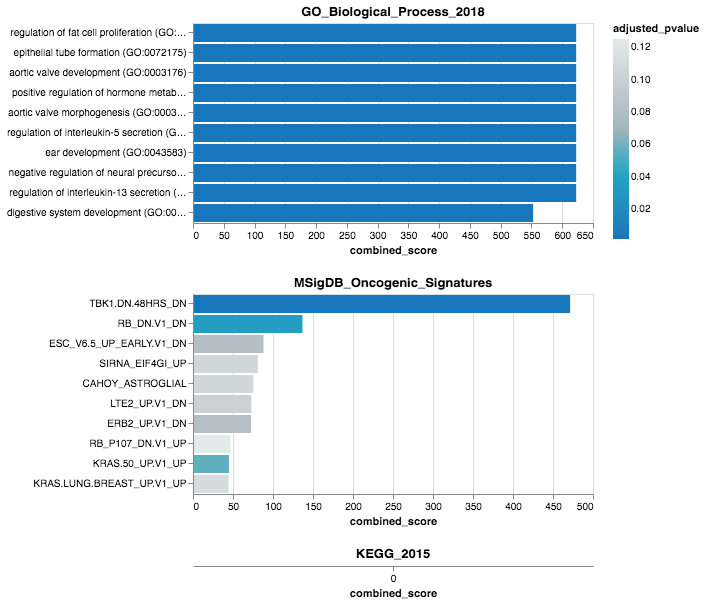

In [33]:
gene_list = genes_by_unit['unit_16']['VCAP']
description = "Genes activating unit 16 the most."
enr = EnrichrQuery(
    gene_list,
    description,
)
enr.enrich(databases)
enr.plot(size=10, pvalue_thresh=0.2)

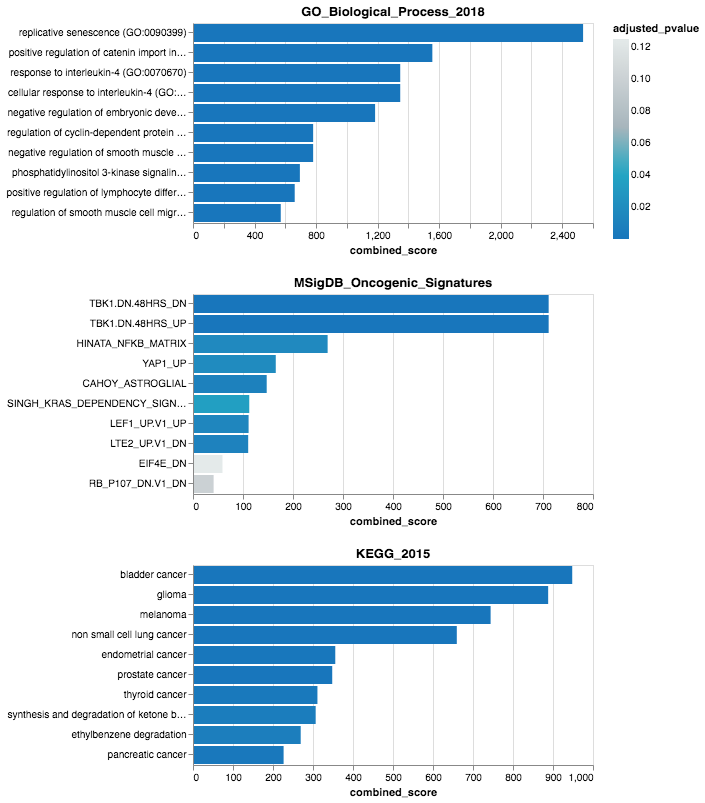

In [34]:
gene_list = genes_by_unit['unit_10']['MCF7']
description = "Genes activating unit 10 the most MCF7."
enr = EnrichrQuery(
    gene_list,
    description,
)
enr.enrich(databases)
enr.plot(size=10, pvalue_thresh=0.2)

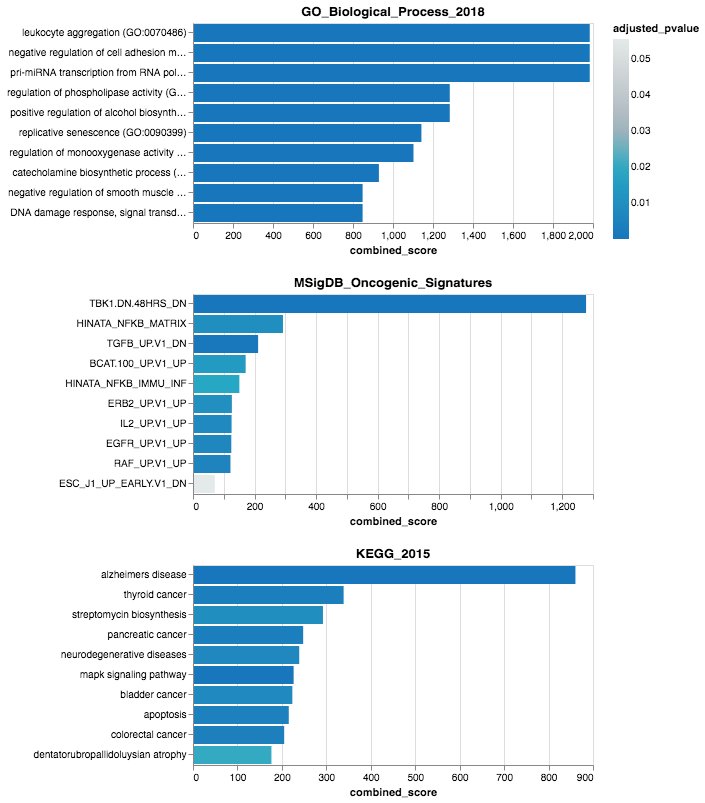

In [35]:
gene_list = genes_by_unit['unit_26']['PC3']
description = "Genes activating unit 26 the most."
enr = EnrichrQuery(
    gene_list,
    description,
)
enr.enrich(databases)
enr.plot(size=10, pvalue_thresh=0.2)